# Creating and Backtesting MACD Strategies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [2]:
data = pd.read_csv("eurusd.csv", parse_dates = ["Date"], index_col = "Date")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4275 entries, 2004-01-01 to 2020-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4275 non-null   float64
dtypes: float64(1)
memory usage: 66.8 KB


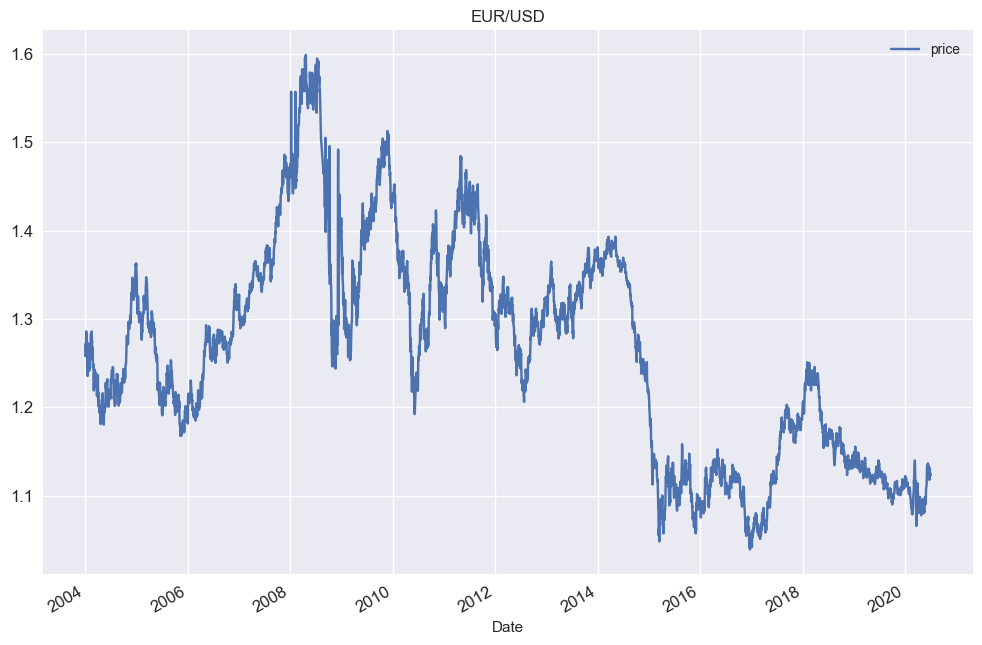

In [4]:
data.plot(figsize = (12, 8), title = "EUR/USD", fontsize = 12)
plt.show()

## Defining an MACD Strategy

In [6]:
ema_s = 12 # EMA Short
ema_l = 26 # EMA Long

In [7]:
data["EMA_S"] = data.price.ewm(span = ema_s, min_periods = ema_s).mean() 

In [8]:
data["EMA_L"] = data.price.ewm(span = ema_l, min_periods = ema_l).mean() 

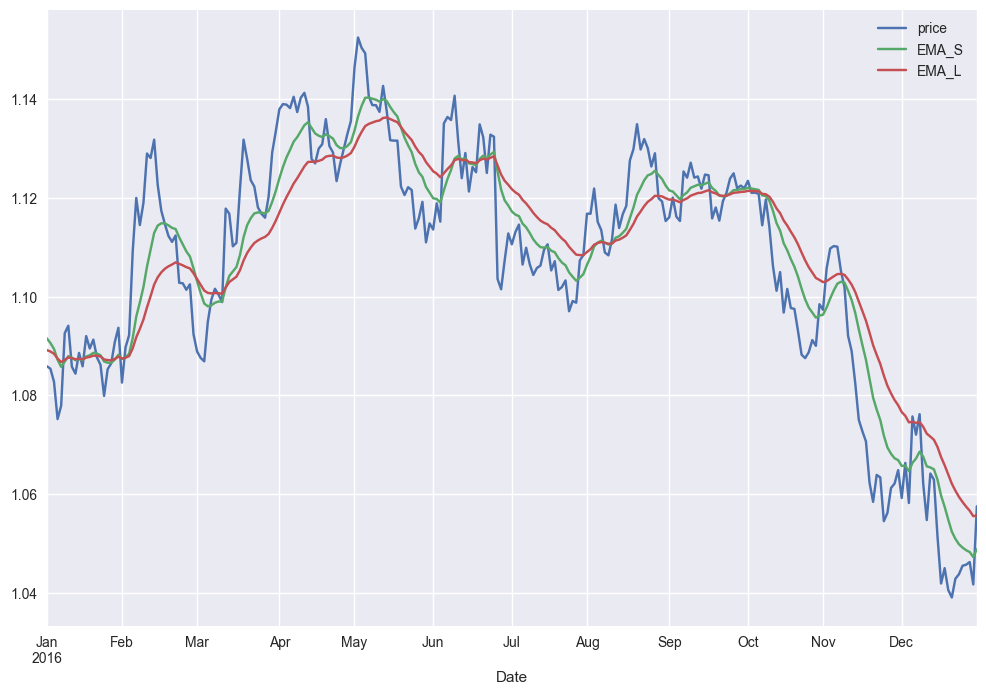

In [9]:
data.loc["2016", ["price", "EMA_S", "EMA_L"]].plot(figsize = (12, 8))
plt.show()

In [10]:
data["MACD"] = data.EMA_S - data.EMA_L

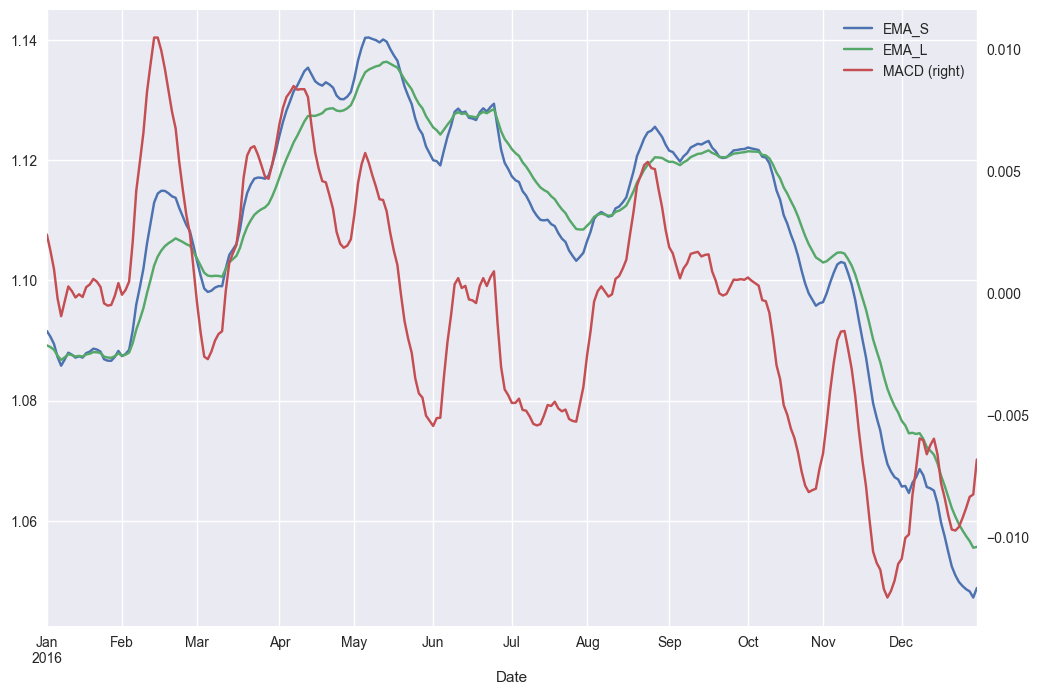

In [11]:
data.loc["2016", ["EMA_S", "EMA_L", "MACD"]].plot(figsize = (12, 8), secondary_y = "MACD")
plt.show()

In [12]:
signal_mw = 9 # Moving Window for Signal Line

In [13]:
data["MACD_Signal"] = data.MACD.ewm(span = signal_mw, min_periods = signal_mw).mean() 

In [14]:
data

,price,EMA_S,EMA_L,MACD,MACD_Signal
Date,,,,,
2004-01-01,1.258194,NaN,NaN,NaN,NaN
2004-01-02,1.258194,NaN,NaN,NaN,NaN
2004-01-05,1.268698,NaN,NaN,NaN,NaN
2004-01-06,1.272103,NaN,NaN,NaN,NaN
2004-01-07,1.264095,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-06-24,1.131235,1.125123,1.117852,0.007272,0.008516
2020-06-25,1.125087,1.125118,1.118388,0.006730,0.008158
2020-06-26,1.122208,1.124670,1.118671,0.005999,0.007727


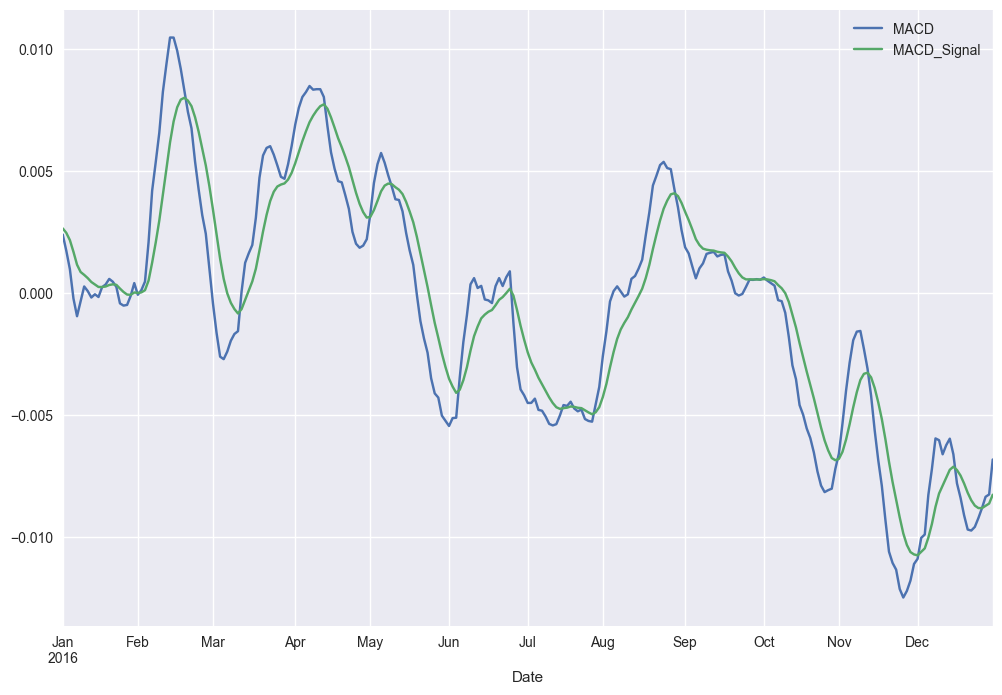

In [15]:
data.loc["2016", ["MACD", "MACD_Signal"]].plot(figsize = (12, 8))
plt.show()